# Setup

In [1]:
renv::load("/project/kohl_analysis/analysis/CAdir")

library(devtools)
devtools::load_all("/home/kohl/PhD/gits/ClemensKohl/CAdir")
library(APL)
library(SingleCellExperiment)
library(scater)
library(scuttle)
library(scran)

library(TENxPBMCData)
library(dplyr)

options(repr.plot.width = 20, repr.plot.height = 15)
getwd()

- The project is out-of-sync -- use `renv::status()` for details.


Loading required package: usethis

ℹ Loading CAdir






Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowM

[1] "/project/kohl_analysis/analysis/CAdir/data/results"

# Pre-process and annotate data
Annotation done according to Seurat vignette.

In [ ]:
sce <- TENxPBMCData::TENxPBMCData(dataset = "pbmc3k")
rownames(sce) <- make.unique(SummarizedExperiment::rowData(sce)$Symbol_TENx)
colnames(sce) <- SummarizedExperiment::colData(sce)$Barcode

pbmc <- SeuratObject::CreateSeuratObject(
    counts = as.matrix(SingleCellExperiment::counts(sce)),
    assay = "RNA",
    project = "pbmc3k",
    min.cells = 3,
    min.features = 200,
    meta.data = as.data.frame(SingleCellExperiment::colData(sce))
)

pbmc[["percent.mt"]] <- Seurat::PercentageFeatureSet(pbmc, pattern = "^MT-")

# Filter data
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
no_zeros_rows <- Matrix::rowSums(pbmc, slot = "counts") > 0
pbmc <- pbmc[no_zeros_rows, ]

# Normalization
pbmc <- Seurat::NormalizeData(
    pbmc,
    normalization.method = "LogNormalize",
    scale.factor = 10000,
    verbose = FALSE
)

pbmc <- Seurat::FindVariableFeatures(
    pbmc,
    # selection.method = "vst",
    nfeatures = 2000,
    verbose = FALSE
)

# Scaling
all.genes <- rownames(pbmc)
pbmc <- Seurat::ScaleData(
    pbmc,
    features = all.genes,
    verbose = FALSE
)

# Run PCA
pbmc <- Seurat::RunPCA(
    pbmc,
    features = Seurat::VariableFeatures(object = pbmc),
    verbose = FALSE
)

# Cell clustering
pbmc <- Seurat::FindNeighbors(pbmc, dims = 1:10, verbose = FALSE)
pbmc <- Seurat::FindClusters(pbmc, resolution = 0.5, verbose = FALSE)

pbmc <- Seurat::RunUMAP(pbmc, dims = 1:10, verbose = FALSE)

new.cluster.ids <- c(
    "0 - Naive CD4 T",
    "1 - CD14+ Mono",
    "2 - Memory CD4 T",
    "3 - B",
    "4 - CD8 T",
    "5 - FCGR3A+ Mono",
    "6 - NK",
    "7 - DC",
    "8 - Platelet"
)

names(new.cluster.ids) <- levels(pbmc)
pbmc <- SeuratObject::RenameIdents(pbmc, new.cluster.ids)
pbmc$cell_type <- SeuratObject::Idents(pbmc)

pbmc <- Seurat::as.SingleCellExperiment(pbmc)


# pbmc3k

In [2]:
set.seed(1234)
sce <- RUtils:::sce_pbmc3k()

sce_bu <- sce
sce.dec <- scran::modelGeneVar(sce)
sce.top <- scran::getTopHVGs(sce.dec, prop = 0.2, var.threshold = NULL)
sce <- sce[sce.top, ]
sce <- runUMAP(sce, ntop = 2000)

ca <- cacomp(
    obj = as.matrix(logcounts(sce)),
    princ_coords = 3,
    dims = 30,
    top = nrow(sce),
    residuals = "pearson",
    python = TRUE
)

see ?TENxPBMCData and browseVignettes('TENxPBMCData') for documentation

loading from cache

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [84]:
set.seed(2358)
cak <- dirclust_splitmerge(
    caobj = ca,
    k = 15,
    cutoff = NULL,
    method = "random",
    apl_quant = 0.99,
    counts = NULL,
    min_cells = 30,
    reps = 5,
    make_plots = TRUE,
    apl_cutoff_reps = 100,
    qcutoff = 0
)

cadir <- rank_genes(cadir = cak, caobj = ca)
top <- top_genes(cadir)

Iteration 1

	Merging cluster_2 with cluster_9

	Merging cluster_3 with cluster_5

	Merging cluster_4 with cluster_7	Merging cluster_4 with cluster_8	Merging cluster_4 with cluster_11

	Merging cluster_7 with cluster_8	Merging cluster_7 with cluster_9

Iteration 2

Iteration 3

Iteration 4

Iteration 5



caclust object with 2638 cells and 2743 genes.
7 clusters found.
Clustering results:

 cluster               ncells ngenes
 Megakaryocyte           21   154   
 Monocyte               666   347   
 Cytotoxic_CD4+_T_cell  399   504   
 B_cell                 348   425   
 cluster_5                4   327   
 cluster_6               10   404   
 Naive_CD8+_T_cell     1190   582   

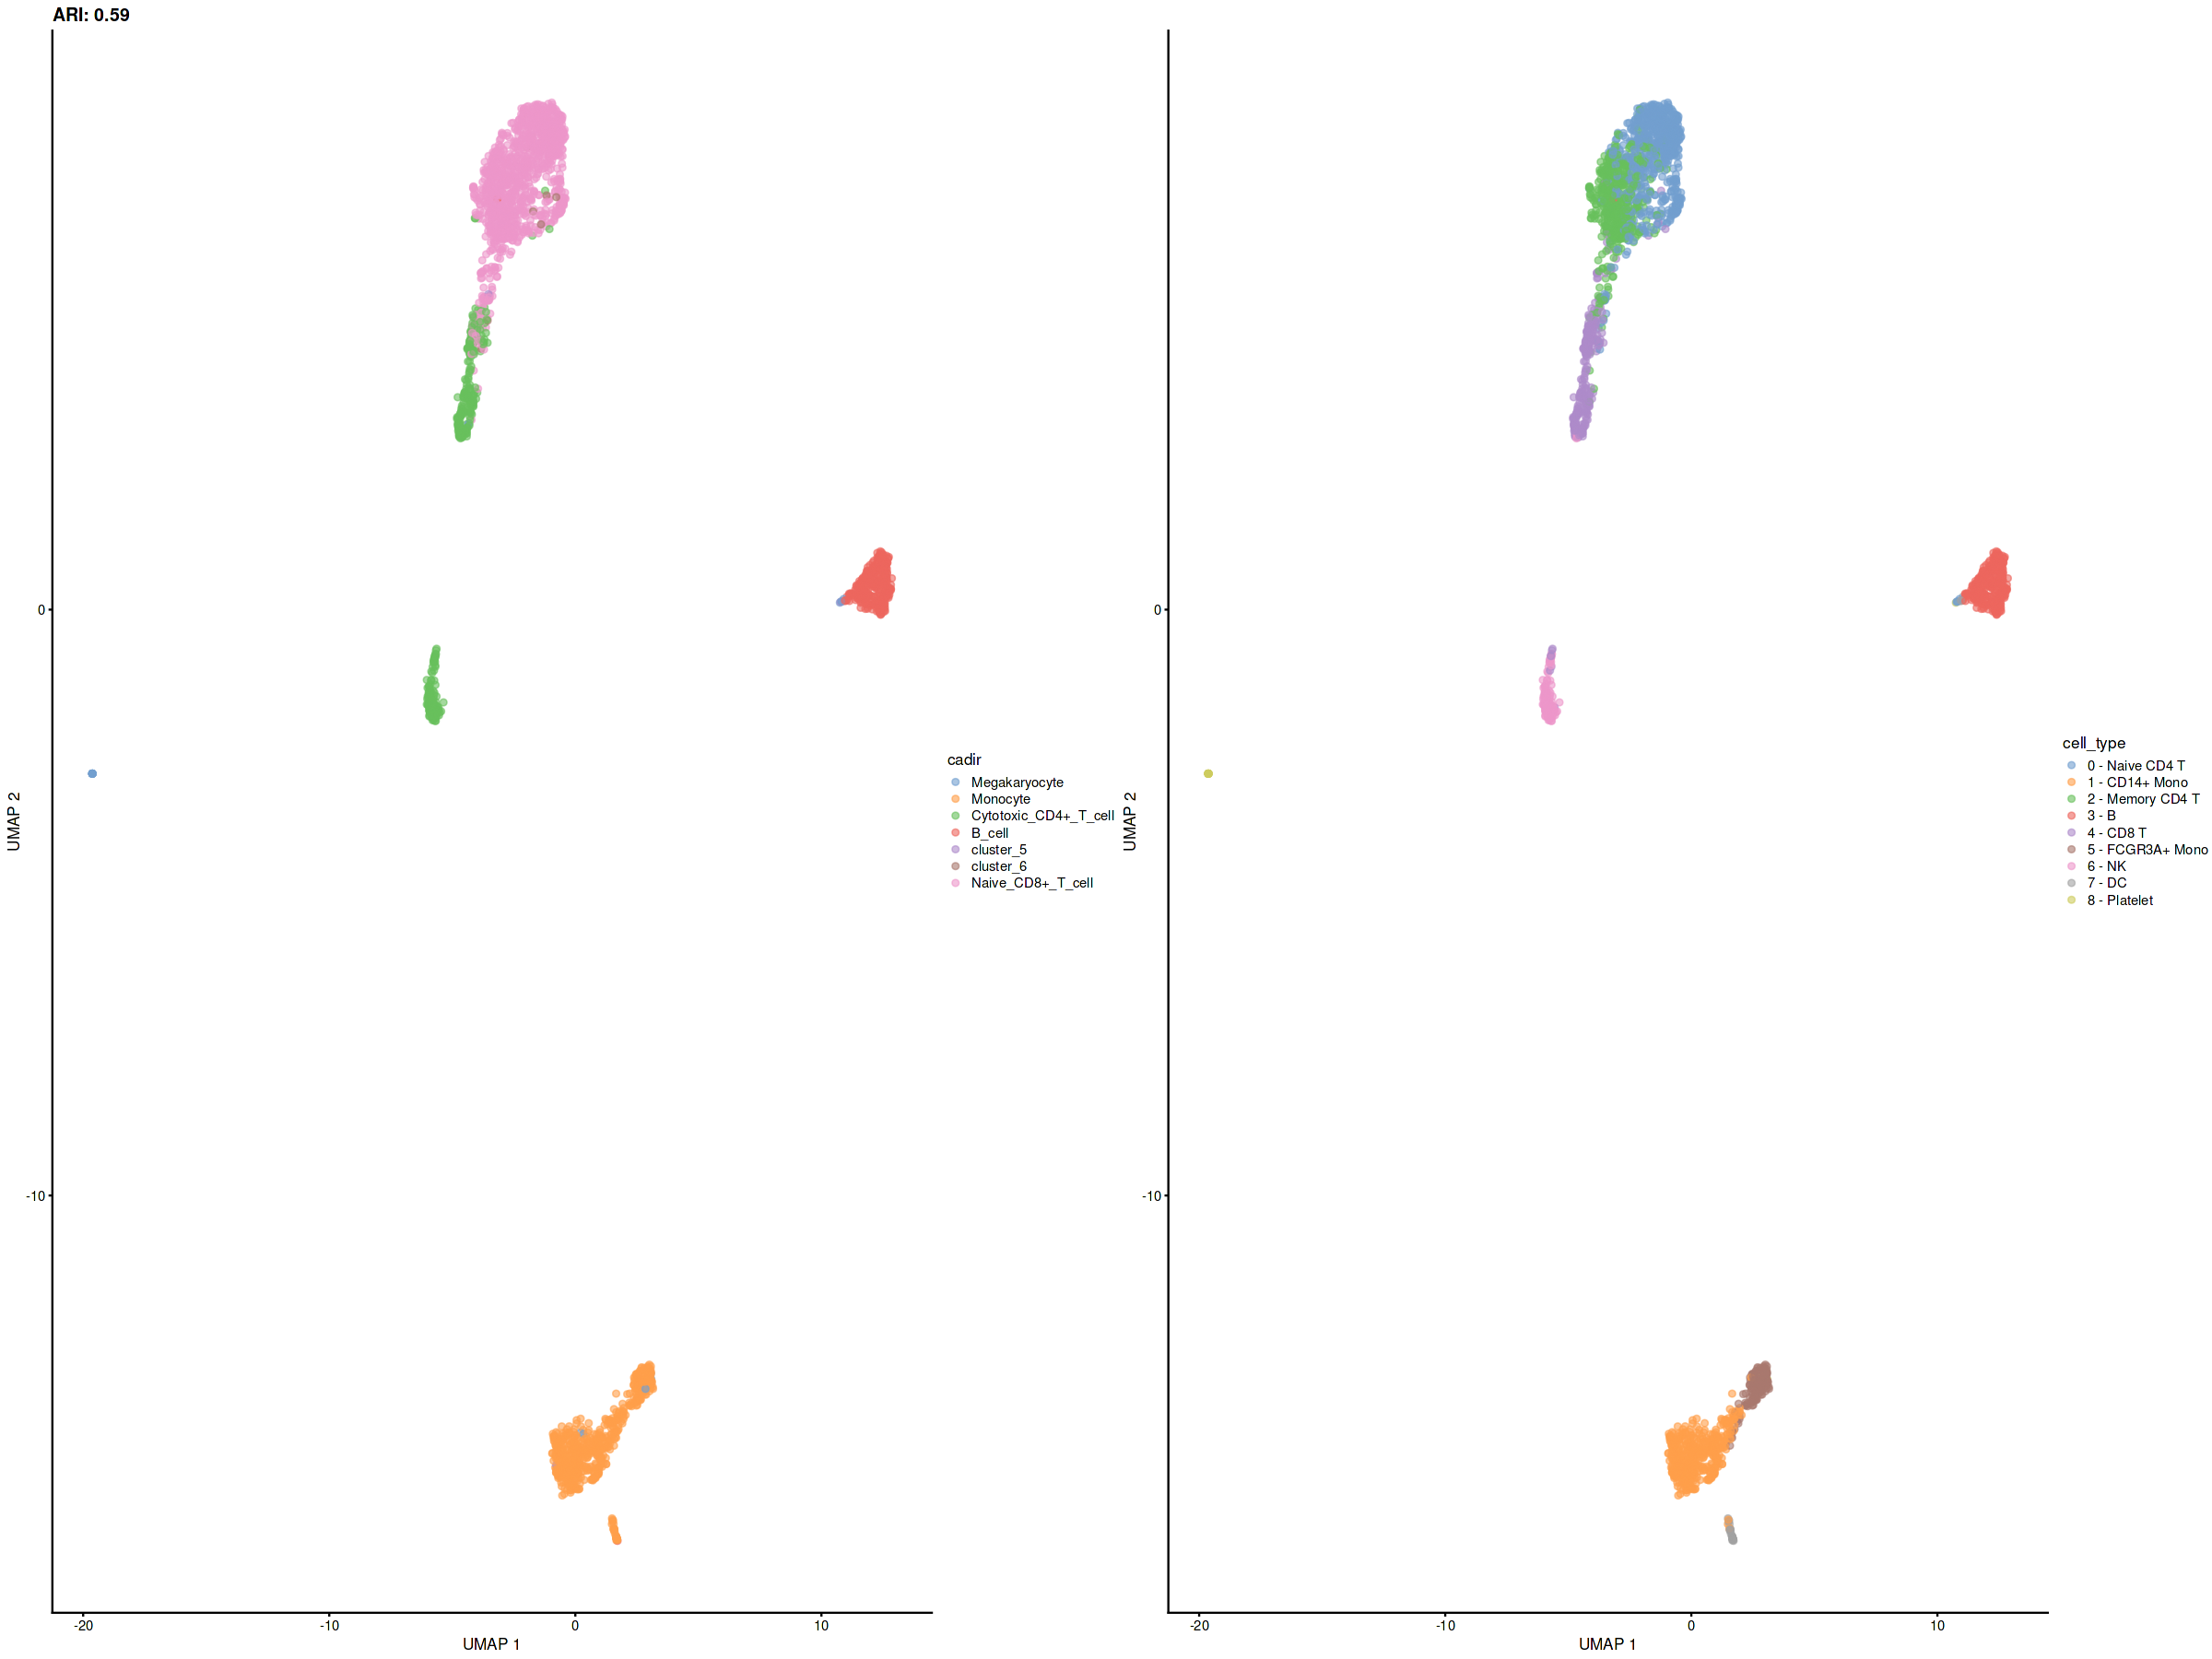

In [85]:
###########
## CAdir ##
###########

anncak <- annotate_biclustering(
    obj = cak,
    universe = rownames(sce),
    org = "hs"
)

anncak <- rank_genes(cadir = anncak, caobj = ca)
anncak

sce$cadir <- anncak@cell_clusters

um1 <- plotUMAP(sce, colour = "cadir")
um2 <- plotUMAP(sce, colour = "cell_type")

ari <- aricode::clustComp(sce$cadir, sce$cell_type)
p <- um1 + ggtitle(paste0("ARI: ", round(ari$ARI, 2))) + um2
p

Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual s

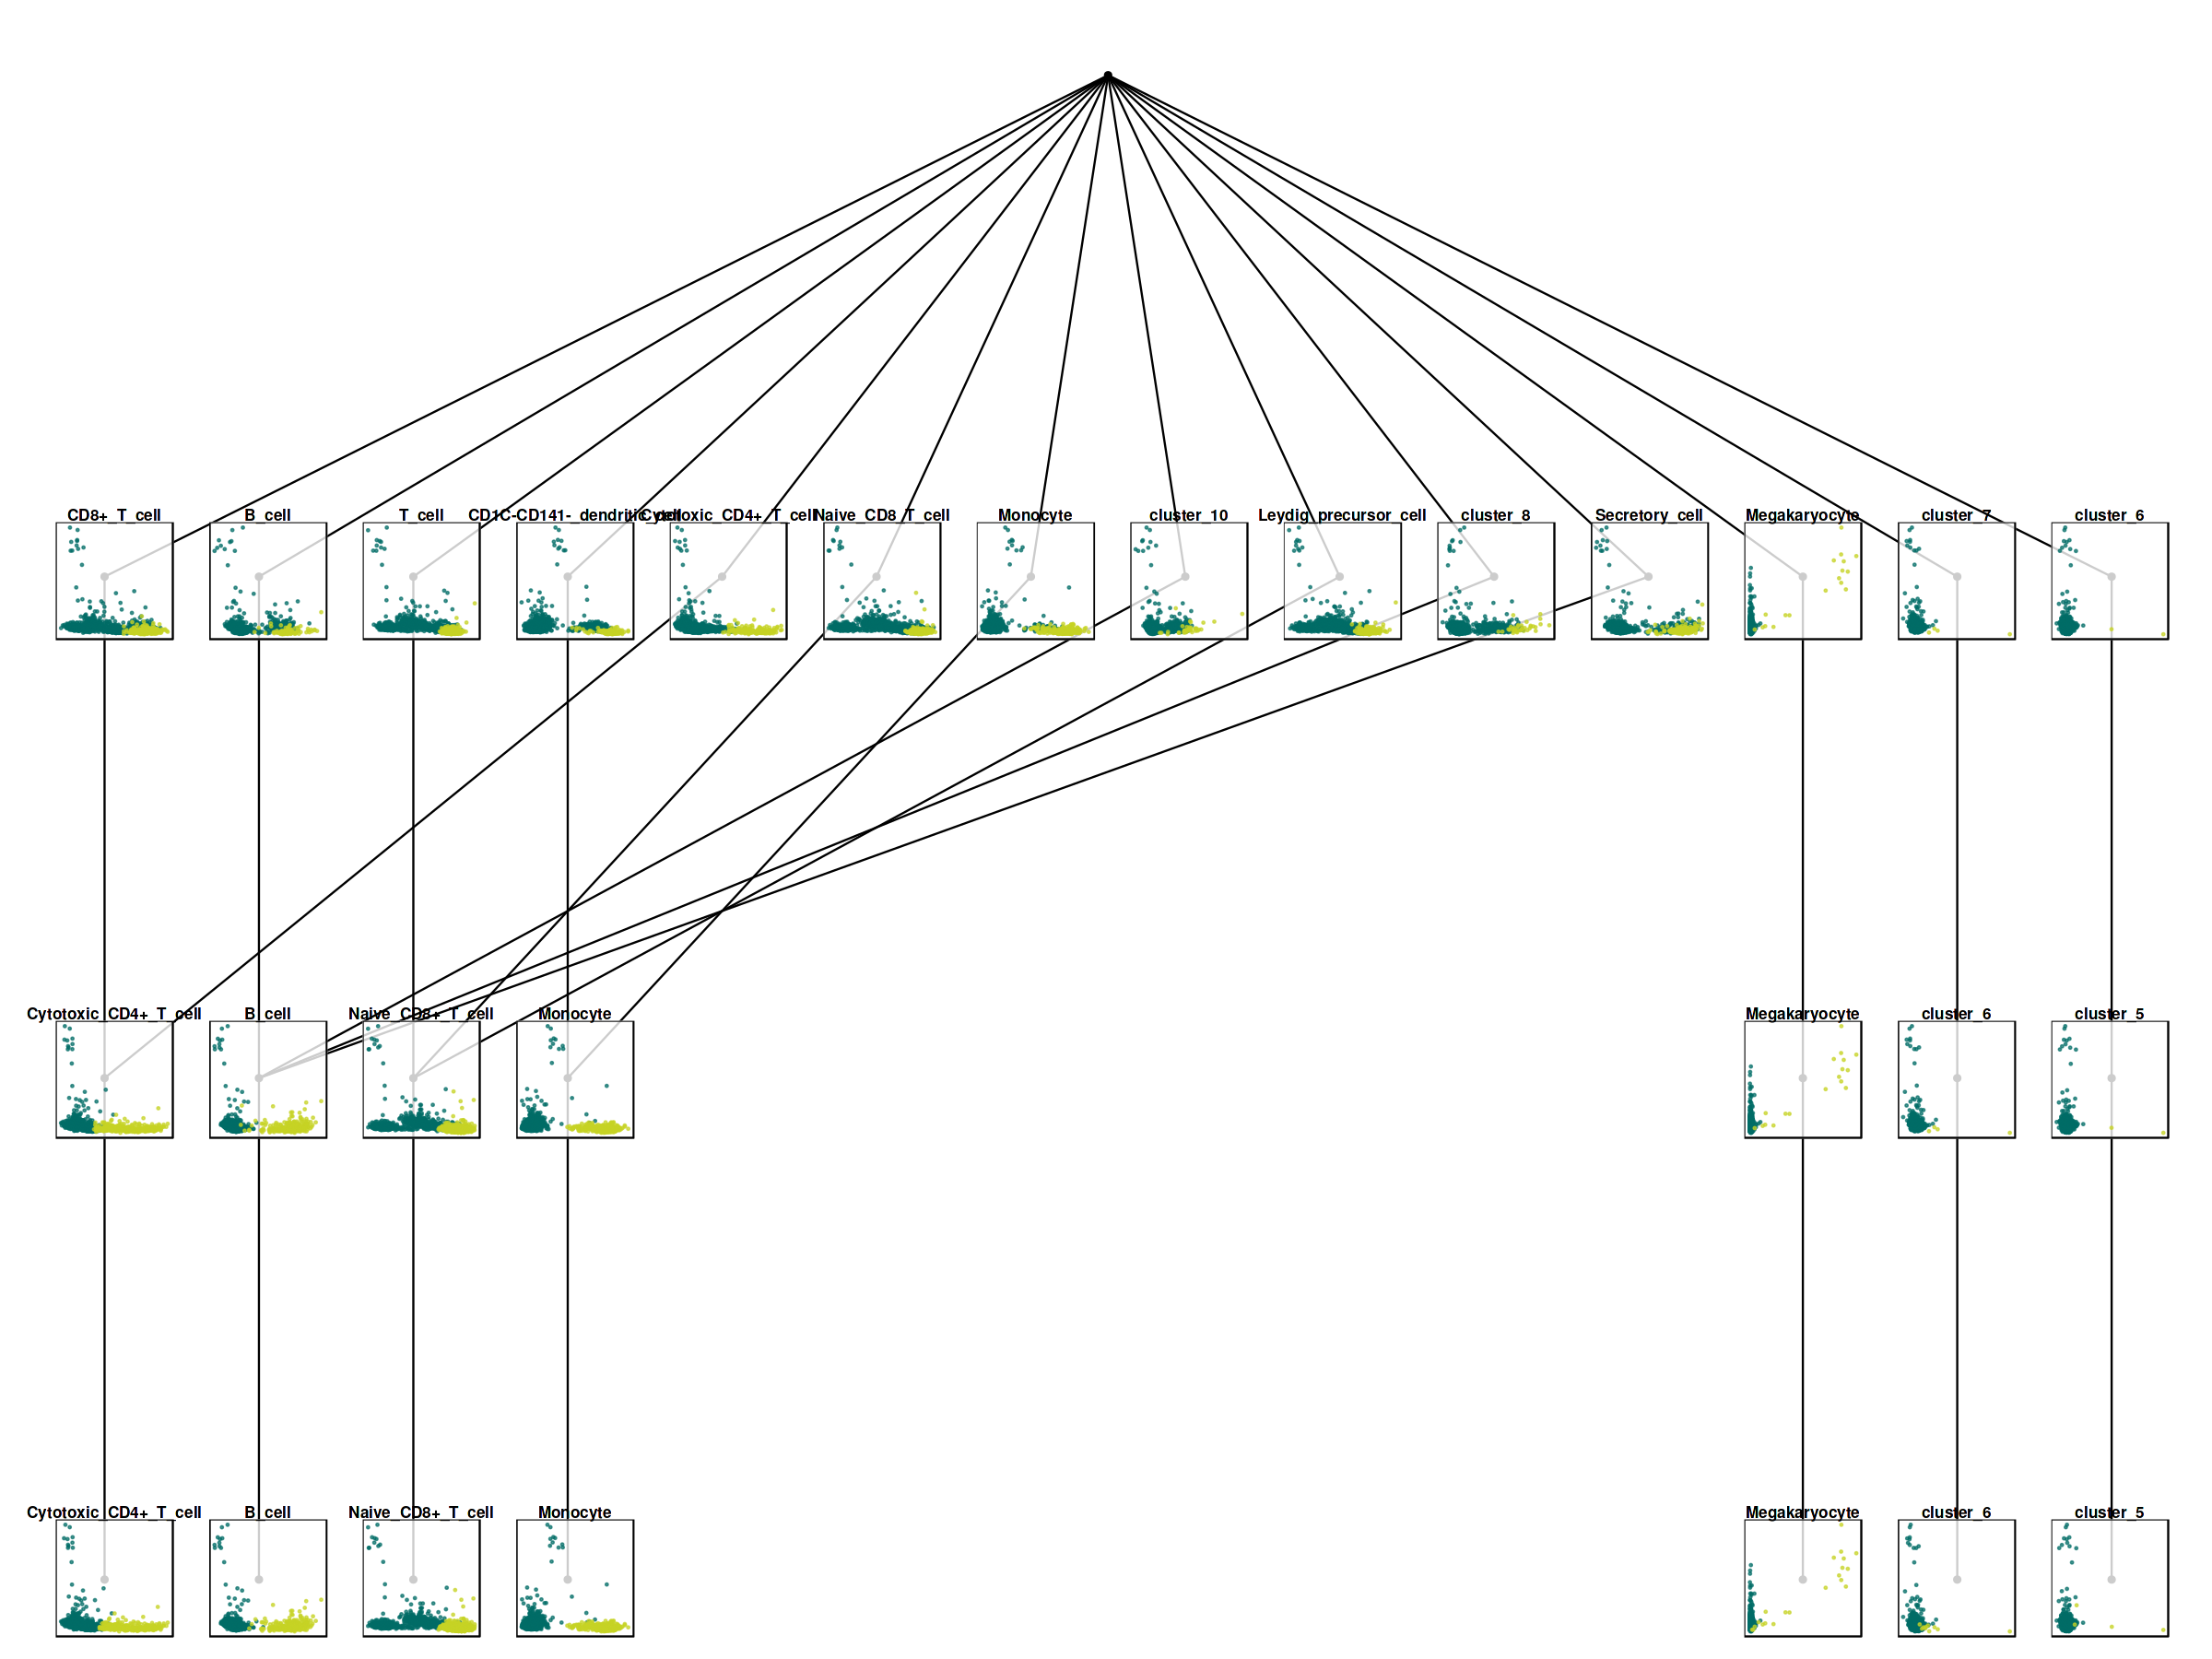

In [86]:
sm_plot(cadir = cak,
        caobj = ca,
        rm_redund = TRUE,
        keep_end = TRUE,
        highlight_cluster = TRUE,
        show_genes = F,
        annotate_clusters = TRUE,
        org = "hs")


Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”


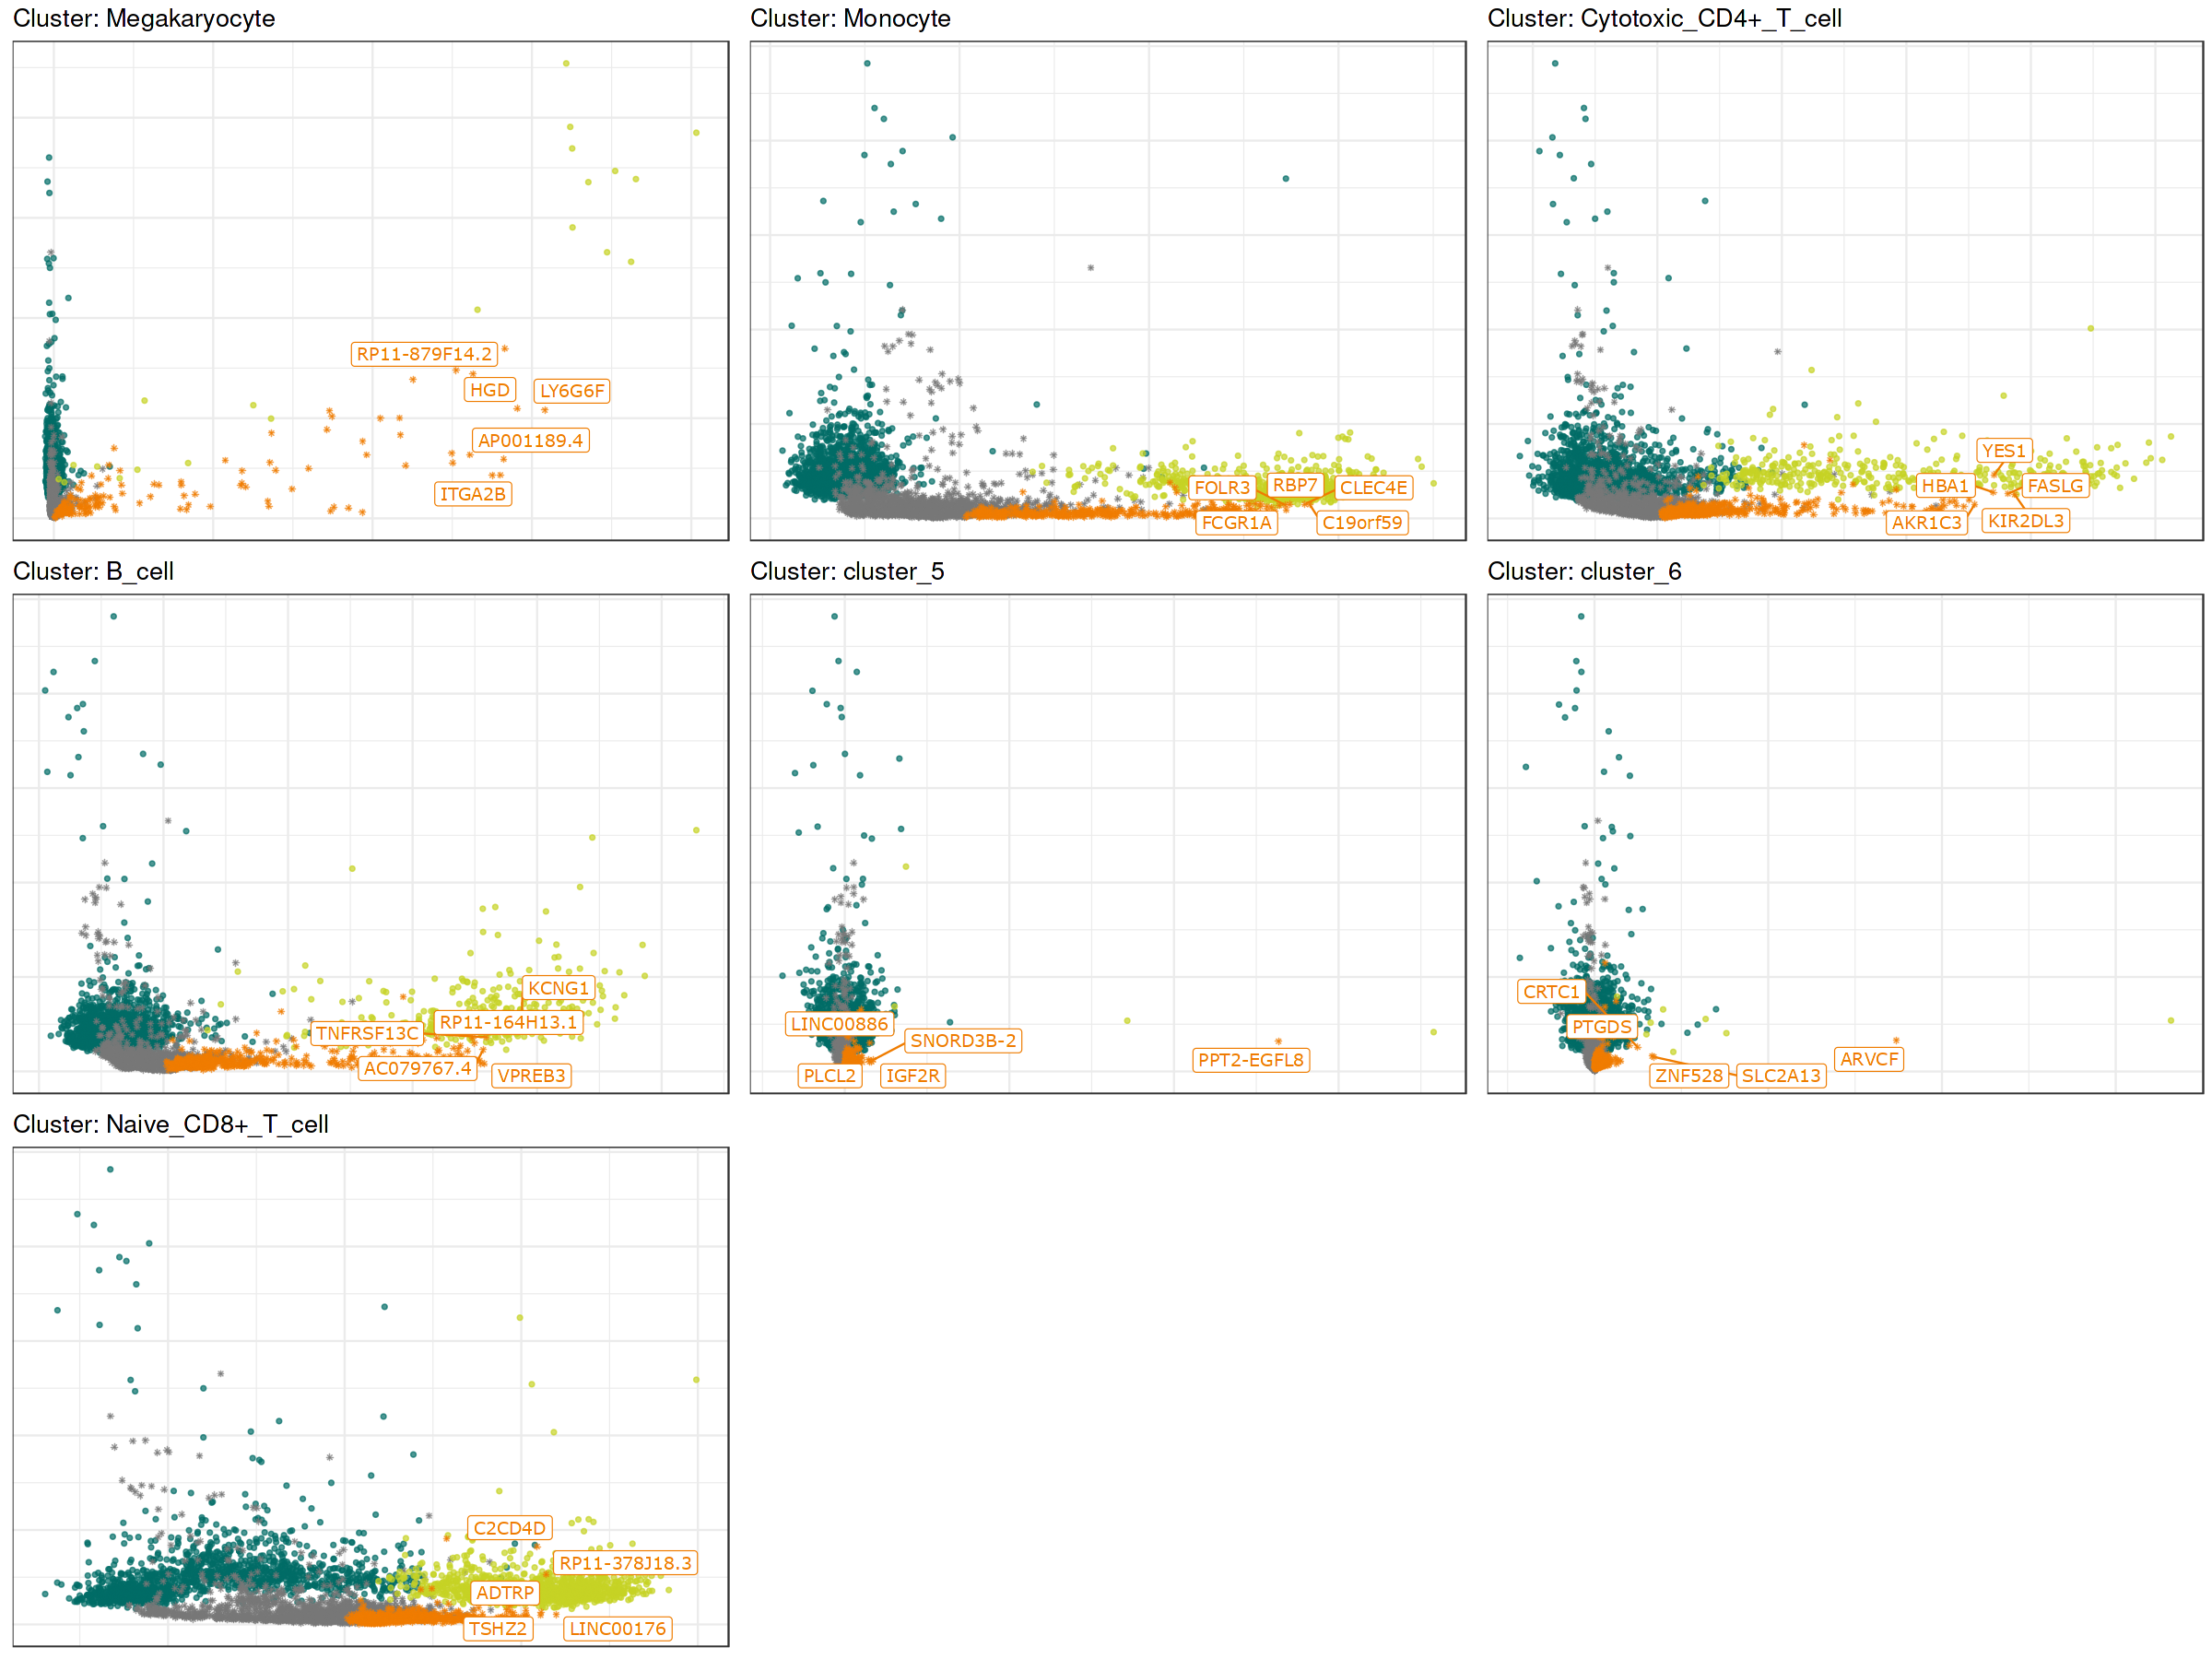

In [87]:
plot_clusters(anncak, ca, show_genes=T, label_genes = T, ntop = 5)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's size values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's size values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's size values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's size values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the data's alpha values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale

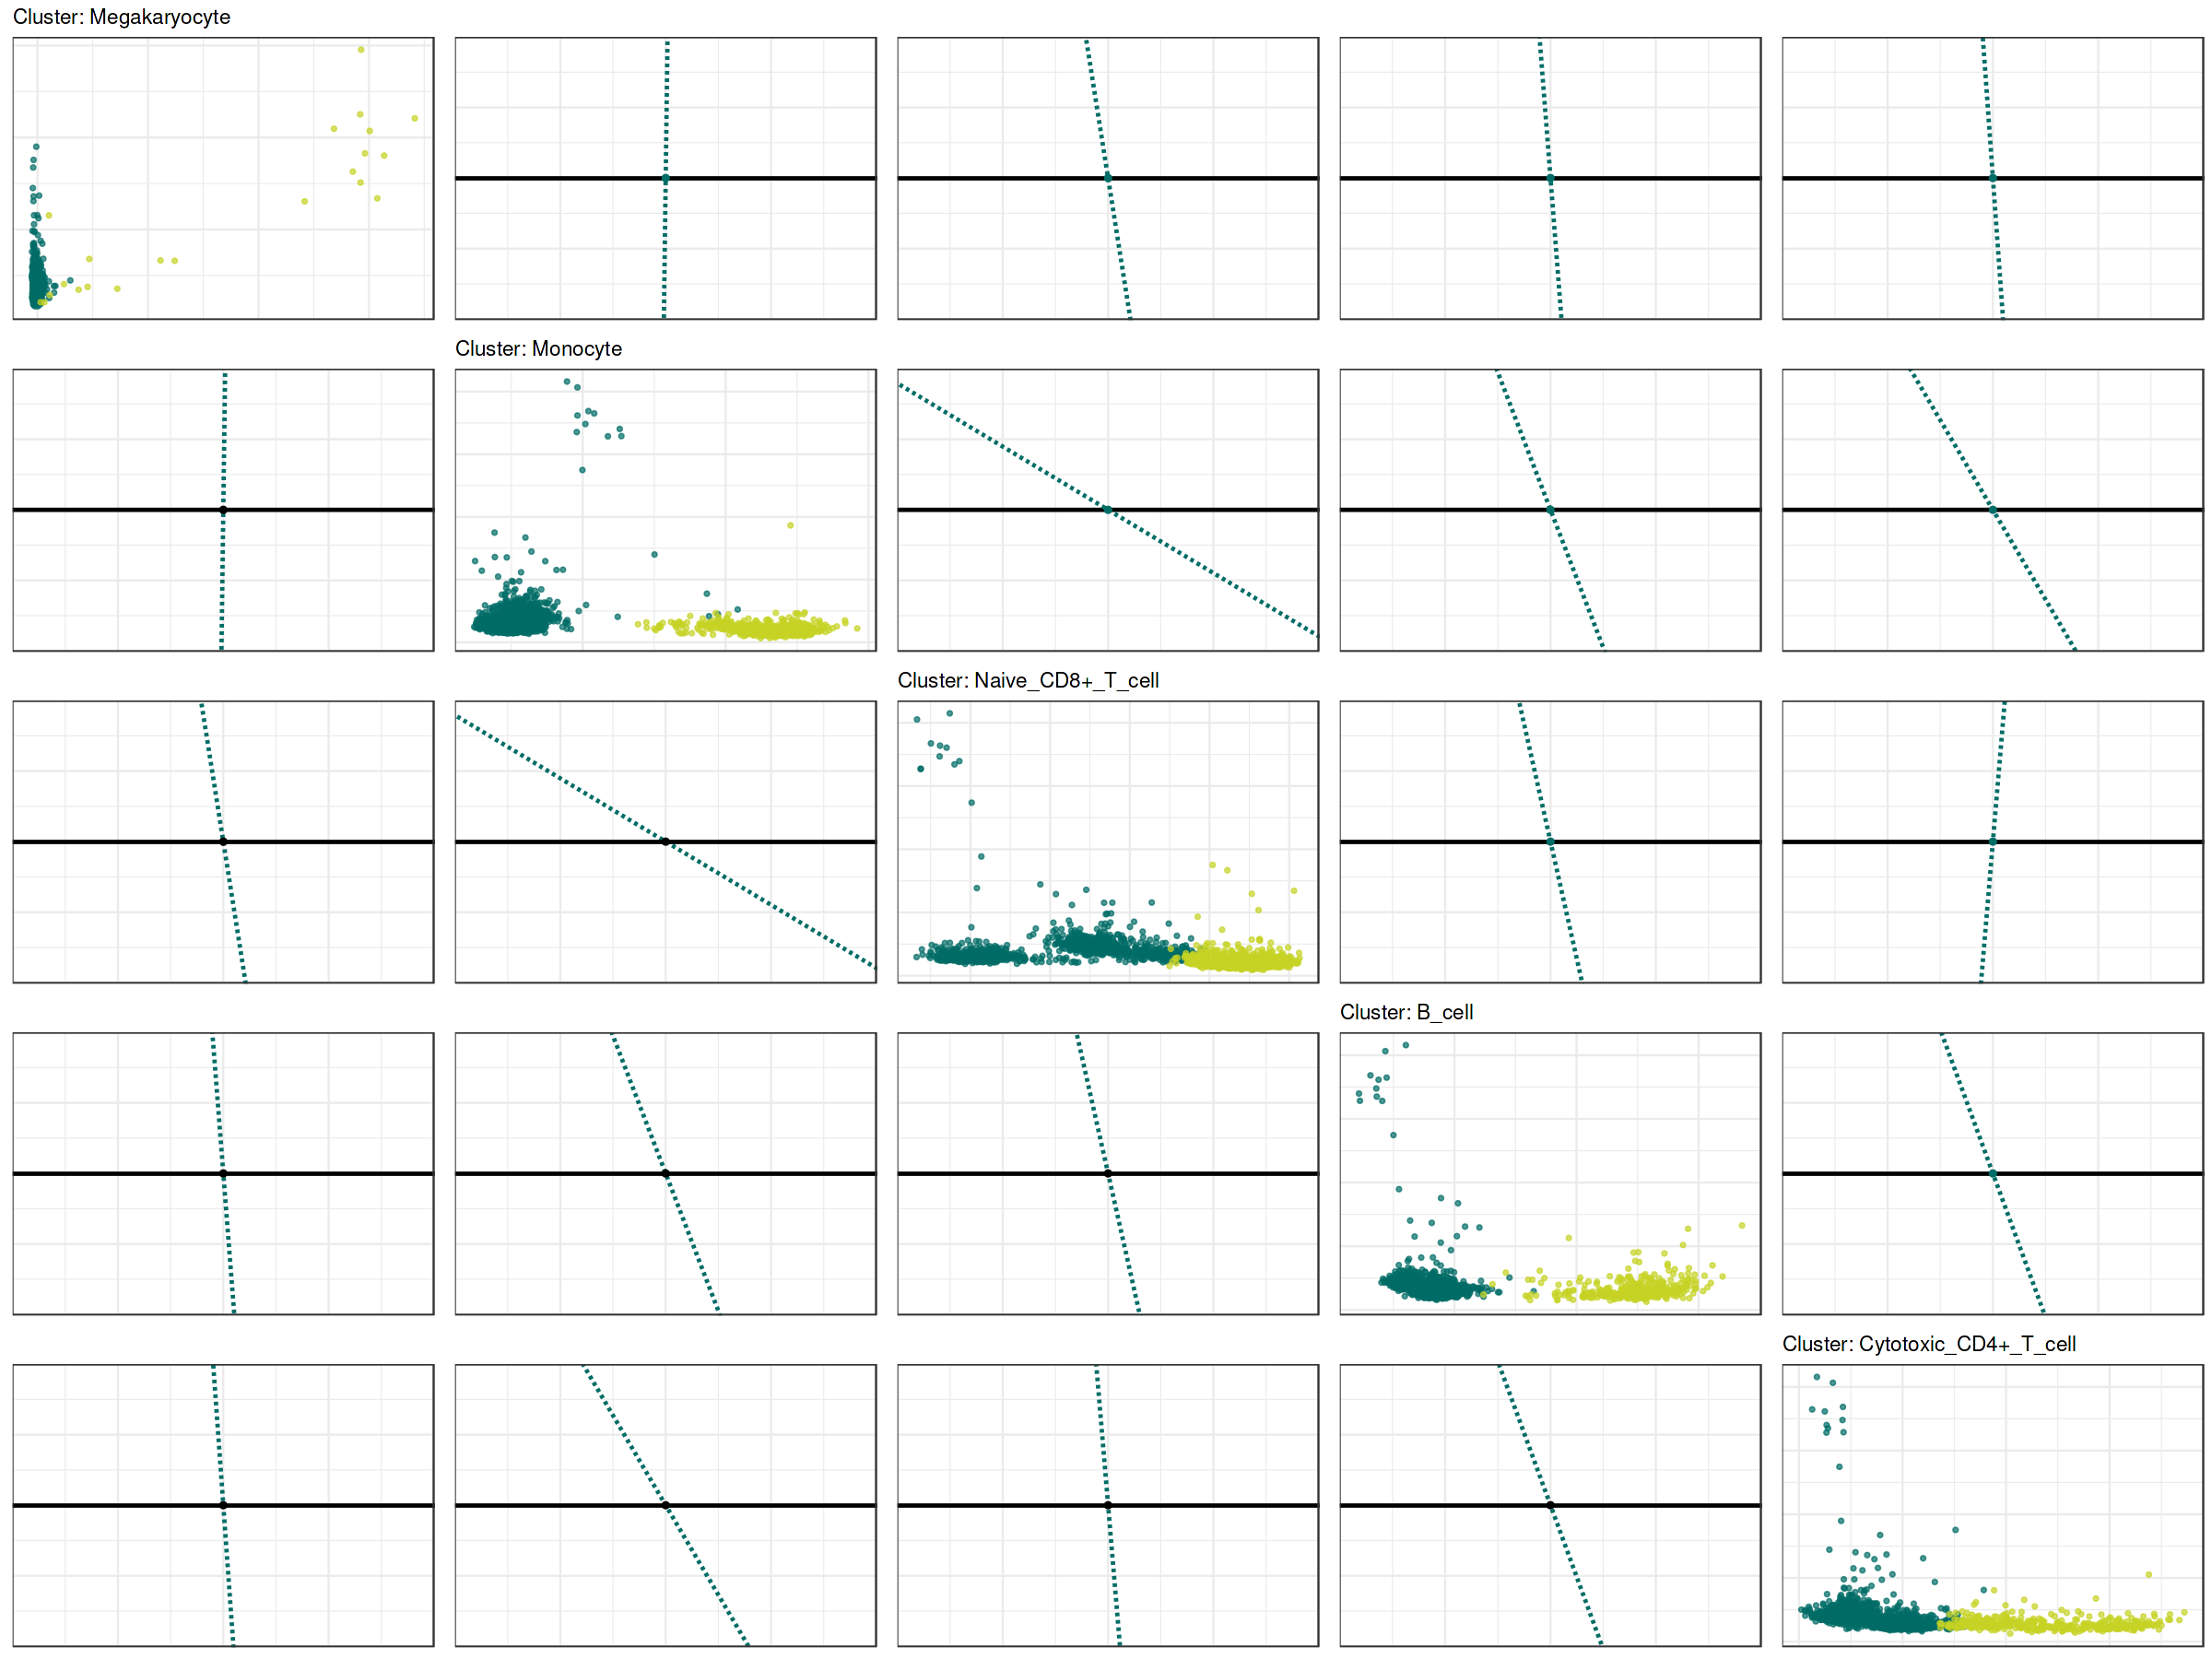

In [69]:
plot_results(anncak, ca)